# Trading the Close


# Project Setup

In [10]:
import pandas as pd
import numpy as np
import os
from structlog import get_logger
import matplotlib.pyplot as plt


logger = get_logger()


## Analysis Parameters

In [2]:
ANALISYS_NUM_DAYS = 10**7
ANALYSIS_NUM_STOCKS = 200

## Constants

In [3]:
REGISTER_PER_STOCK_PER_DAY = 55
STOCKS_ALL_DAYS = tuple(set(range(0, 200)) - {99, 69, 102, 135, 199, 73, 78, 79, 150, 153, 156})
logger.info("STOCKS_ALL_DAYS", STOCKS_ALL_DAYS=len(STOCKS_ALL_DAYS))

2024-02-20 00:45:04 [info     ] STOCKS_ALL_DAYS                STOCKS_ALL_DAYS=189


## Load Dataset

In [4]:
df = pd.read_csv('trading_the_close_data/train.csv')

# Filter to work with assets that are traded every day
df = df[df['stock_id'].isin(STOCKS_ALL_DAYS[:ANALYSIS_NUM_STOCKS])] 

# Slice the df to ease the analysis
df = df.sort_values(by=['date_id', 'stock_id'], ascending=[True, True]).iloc[:REGISTER_PER_STOCK_PER_DAY * ANALISYS_NUM_DAYS * ANALYSIS_NUM_STOCKS, :]

# Show descriptive statistics
# print(df.describe())

In [5]:
'''
Here we have some basic statistics about the data and sannity checks
'''

# Number of records
logger.info('Number of records', num_records=len(df))

# Number of stocks
num_stocks = len(df['stock_id'].unique())
logger.info('Number of stocks', num_stocks=num_stocks)

# Assert the Number of stocks per day is consistent
assert all(c == num_stocks for c in df[["date_id", "stock_id"]][~df.duplicated(["date_id", "stock_id"])].groupby('date_id').count().values), 'Number of stocks per day is not consistent'

# Number of days
logger.info('Number of days', num_days=len(df['date_id'].unique()))

# Number of records per stock per day
records_per_stock_per_day = df.groupby(['stock_id', 'date_id']).count()
assert all(r == REGISTER_PER_STOCK_PER_DAY for r in records_per_stock_per_day["seconds_in_bucket"].values), 'Number of records per stock per day is not consistent'
logger.info('Number of records per stock per day', records_per_stock_per_day=records_per_stock_per_day)


records_per_stock_per_day = df[["stock_id", "date_id", "seconds_in_bucket"]].groupby(['stock_id', 'date_id'])
assert all( np.array_equal(v["seconds_in_bucket"].values, records_per_stock_per_day.get_group((0,0))['seconds_in_bucket'].values) for _, v in records_per_stock_per_day), 'Number of records per stock per day is not consistent'
logger.info('Time range per stock per day', count=records_per_stock_per_day.count().values[0], min=records_per_stock_per_day.min().values[0], max=records_per_stock_per_day.max().values[0])


2024-02-20 00:45:11 [info     ] Number of records              num_records=4999995
2024-02-20 00:45:11 [info     ] Number of stocks               num_stocks=189
2024-02-20 00:45:12 [info     ] Number of days                 num_days=481
2024-02-20 00:45:12 [info     ] Number of records per stock per day records_per_stock_per_day=                  seconds_in_bucket  imbalance_size  imbalance_buy_sell_flag  \
stock_id date_id                                                               
0        0                       55              55                       55   
         1                       55              55                       55   
         2                       55              55                       55   
         3                       55              55                       55   
         4                       55              55                       55   
...                             ...             ...                      ...   
198      476                 

## Export the data per stock


In [7]:
path = os.path.join("trading_the_close_data", "data_per_stock")
os.makedirs(path, exist_ok=True)

for stock in STOCKS_ALL_DAYS[:ANALYSIS_NUM_STOCKS]:
    df_stock = df[df['stock_id'] == stock]
    df_stock.to_csv(os.path.join(path, f"stock_{stock}.csv"), index=False)

<Axes: xlabel='seconds_in_bucket_global', ylabel='bid_ask_ratio'>

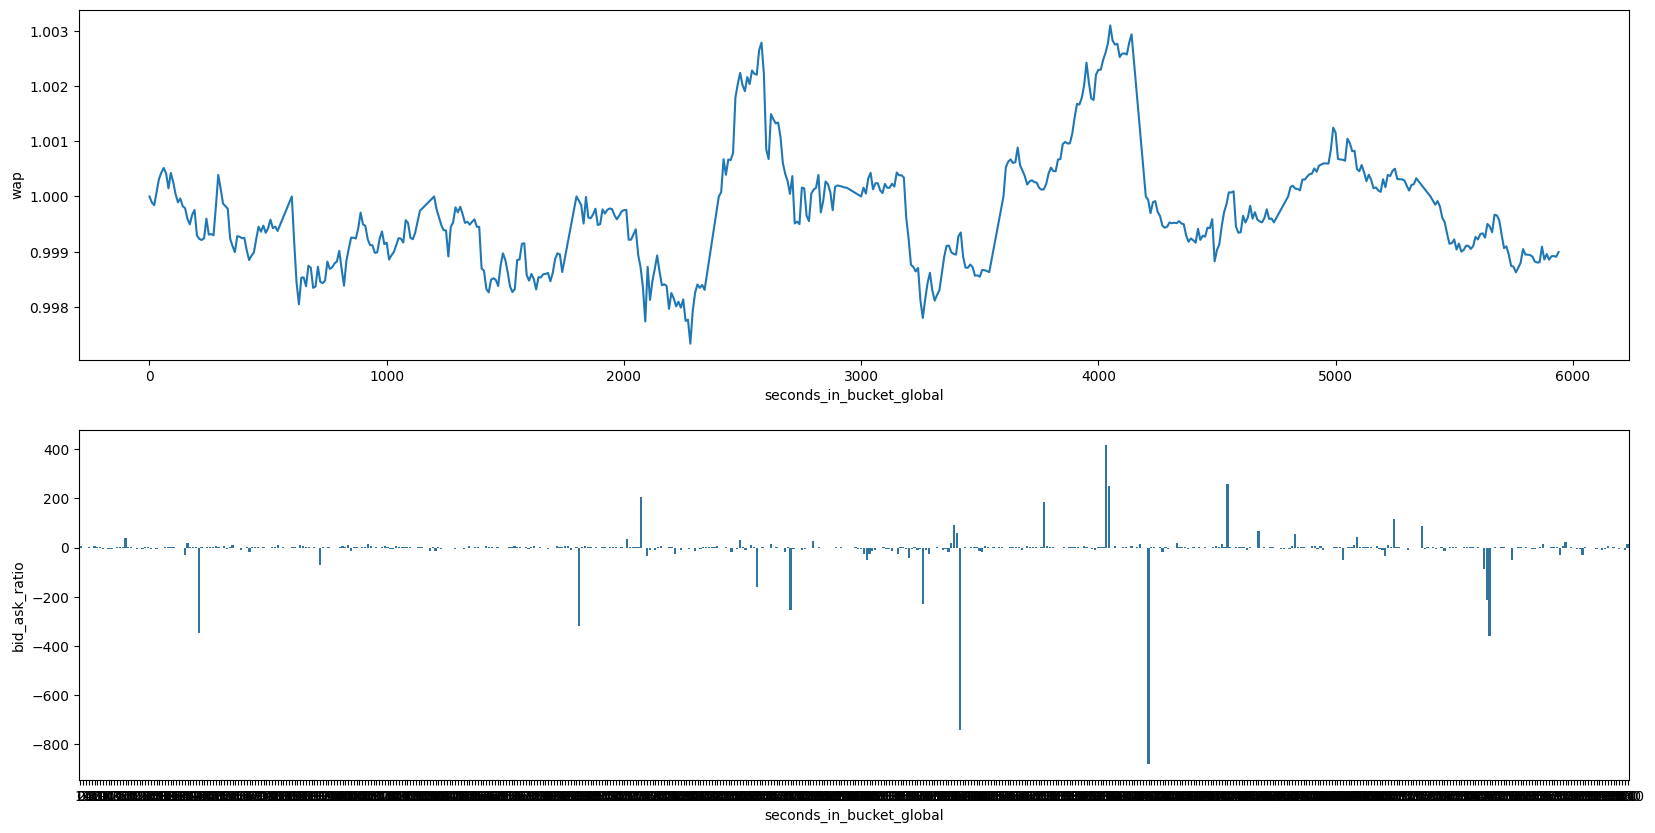

In [15]:
#One stock analsysis

STOCK = 0
df_one_stock = pd.read_csv(os.path.join(path, f"stock_{STOCK}.csv")).iloc[:55 * 10, :]

#plot a line an a barchar similar to those of the stocks
import seaborn as sns

df_one_stock["bid_ask_ratio"] = [bid/ask if bid>=ask else -ask/bid for bid, ask in zip(df_one_stock["bid_size"], df_one_stock["ask_size"])]
df_one_stock["seconds_in_bucket_global"] = df_one_stock["seconds_in_bucket"] + df_one_stock["date_id"] * 600
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x="seconds_in_bucket_global", y="wap", data=df_one_stock, ax=ax[0])
sns.barplot(x="seconds_in_bucket_global", y="bid_ask_ratio", data=df_one_stock, ax=ax[1], )


In [ ]:
STOCK = 0
df_one_stock = pd.read_csv(os.path.join(path, f"stock_{STOCK}.csv")).iloc[:55 * 10, :]

#plot a line an a barchar similar to those of the stocks
import seaborn as sns

df_one_stock["bid_ask_ratio"] = [bid/ask if bid>=ask else -ask/bid for bid, ask in zip(df_one_stock["bid_size"], df_one_stock["ask_size"])]
df_one_stock["seconds_in_bucket_global"] = df_one_stock["seconds_in_bucket"] + df_one_stock["date_id"] * 600
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x="seconds_in_bucket_global", y="wap", data=df_one_stock, ax=ax[0])
sns.barplot(x="seconds_in_bucket_global", y="bid_ask_ratio", data=df_one_stock, ax=ax[1], )